<a href="https://colab.research.google.com/github/Sally-Ama-Sampson/Estimating-Tair-from-CS-generated-Data-/blob/main/Temporal%20Gradient%20Correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Temporal gradient of near surface air temperature

### 1 Data preprocessing to extract time and temperature recordings

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import random
import time
import math
import sys
import matplotlib.pyplot as plt
import os

In [ ]:
timeseries='kunMUK.csv'
Kundf = pd.read_csv(timeseries, sep=';')
Kundf["Temp ext (C)"] = Kundf["Temp ext (C)"].str.replace(',', '.').astype(float)

In [ ]:
Kundf['time'] = Kundf.Datetime.str[11:]
Kundf['time'] = pd.to_datetime(Kundf['time'])
Kundf

In [ ]:
# Considering only timeperiod of transect
Kundf = Kundf[((Kundf['time'].dt.hour == 15) & (Kundf['time'].dt.minute >= 10)) |
              ((Kundf['time'].dt.hour == 16) & (Kundf['time'].dt.minute <= 50))]


In [ ]:
Kundf= Kundf.sort_values(by='time')
Kundf= Kundf.reset_index(drop=True)
ax1 = Kundf.plot.scatter(x='time',
                      y='Temp ext (C)')

In [ ]:
Kundf['TimeSecs'] = Kundf['time'].dt.hour * 3600  + Kundf['time'].dt.minute* 60  + Kundf['time'].dt.second
Kundf.rename(columns={'Temp ext (C)': 'Temperature°C'}, inplace=True)
Kundf.drop(columns=['Heat Index (C)', 'Humidity ext (%)', 'Unnamed: 6'], inplace=True)
Kundf

In [ ]:
Kundf.to_csv('KUNMUKXTRA.csv' , index = False)

##  2 Compare Kunak (KUN) Trend with all Fixed Kestrels (KES)

In [ ]:
#But before, clean the KES
path = '/home/jovyan/Thesis /PREPROCESSING AT /Filtering and Matching/MUKURU/TEMPORAL/FixedKerstrel/FIXED_FILT/OUTLIERSclean/XTRA'
file_names = ['11XTRACLEAN_OUT.csv', '12XTRACLEAN_OUT.csv', '13XTRACLEAN_OUT.csv', '15XTRACLEAN_OUT.csv',
              '16XTRACLEAN_OUT.csv', '17XTRACLEAN_OUT.csv', '18XTRACLEAN_OUT.csv']
dfs = {}
for file_name in file_names:
    df_name = file_name.split('.')[0] + 'df'
    file_path = os.path.join(path, file_name)
    dfs[df_name] = pd.read_csv(file_path)
KUN = Kundf

In [ ]:
for df_name, df in dfs.items():
    df['Actual_Datetime'] = pd.to_datetime(df['Actual_Datetime'])
    df['TimeSecs'] = df['Actual_Datetime'].dt.hour * 3600 + df['Actual_Datetime'].dt.minute* 60  + df['Actual_Datetime'].dt.second

In [ ]:
fig, ax = plt.subplots()
for df_name, df in dfs.items():
    df.plot(x='TimeSecs', y='cleanTemp', ax=ax, label=df_name,color='blue')
KUN.plot(x='TimeSecs', y='Temperature°C', ax=ax, label='KUN', color='orange')
ax.set_xlabel('TimeSecs')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Scatter Plot of Temperature vs. Time')
ax.legend(fontsize=5)
plt.show()

# Smooth all the noise by applying moving average (smoothed at an interval of 2 mins)

In [ ]:
smoothed_values = []
for df_name, df in dfs.items():
    df['Smoothed_Temp'] = df['cleanTemp'].rolling(window=12, min_periods=1).mean()
    smoothed_values.append(df['Smoothed_Temp'])
for df_name, smoothed_value in zip(dfs.keys(), smoothed_values):
    plt.plot(dfs[df_name]['TimeSecs'], smoothed_value, label=f'{df_name} Smoothed')
plt.xlabel('Time')
plt.ylabel('Smoothed Temperature (°C)')
plt.legend(fontsize=7)
plt.show()


In [ ]:
smoothed_df = pd.concat(smoothed_values, axis=1)
mean_smoothed_values = smoothed_df.mean(axis=1)
mean_smoothed_values

In [ ]:
mean_smoothed_values = mean_smoothed_values.iloc[:len(dfs[df_name]['TimeSecs'])]
plt.plot(dfs[df_name]['TimeSecs'], mean_smoothed_values, '--', label='Mean Smoothed Values', color='red')
for df_name, smoothed_value in zip(dfs.keys(), smoothed_values):
    plt.plot(dfs[df_name]['TimeSecs'], smoothed_value, label=f'{df_name} Smoothed', color='blue')
plt.xlabel('Time')
plt.ylabel('Smoothed Temperature (°C)')
plt.legend(fontsize='small',prop={'size': 6})
plt.show()




In [ ]:
mean_smoothed_values = mean_smoothed_values.iloc[:len(KUN['TimeSecs'].values)]
plt.plot(KUN['TimeSecs'].values, KUN['Temperature°C'].values, label=f'KUN' )
plt.plot(KUN['TimeSecs'][0:], mean_smoothed_values, '--', label='Mean Smoothed Values', color = 'red')

plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend(fontsize='small',prop={'size': 6})
plt.show()



### 2 Data fit to model timeseries of temperature recordings

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
# determining best fit
Data = Kundf['TimeSecs'].values.reshape(-1, 1)
x = MinMaxScaler().fit_transform(Data)
y = Kundf['Temperature°C'].values
all_y_pred = []
all_r2_scores = []
for degree in range(1, 20):
    poly_features = PolynomialFeatures(degree=degree)
    x_poly = poly_features.fit_transform(x)
    model = LinearRegression()
    model.fit(x_poly, y)
    y_pred = model.predict(x_poly)
    r2 = r2_score(y, y_pred)
    all_y_pred.append(y_pred)
    all_r2_scores.append(r2)
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', label='Original data')

for degree, y_pred in zip(range(1, 20), all_y_pred):
    plt.plot(x, y_pred, label=f'Degree {degree}, R-squared = {all_r2_scores[degree-1]:.2f}')

plt.xlabel('TimeSecs')
plt.ylabel('Temp ext (C)')
plt.title('Polynomial Regression Fits')
plt.legend(fontsize=7)
plt.grid(True)
plt.show()


In [ ]:
z = np.polyfit(x, y, 17)
z

array([ 3.84525914e+08, -3.18691226e+09,  1.20065624e+10, -2.72145055e+10,
        4.14007276e+10, -4.46551686e+10,  3.51780791e+10, -2.05493223e+10,
        8.94853510e+09, -2.89736569e+09,  6.90434302e+08, -1.18802861e+08,
        1.43027147e+07, -1.14445836e+06,  5.59958059e+04, -1.47590970e+03,
        1.81676122e+01,  3.20743462e+01])

In [ ]:
p = np.poly1d(z)
print(p(0))
print(p(0.5))
print(p(1))

32.07434624590319
31.805346818867356
29.313819356886334


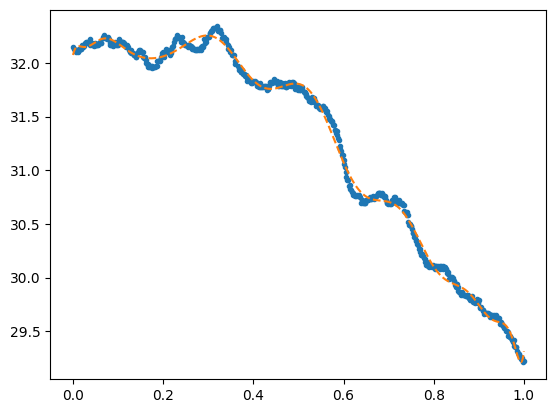

In [ ]:
xp = np.linspace(0,1, 7000)
_ = plt.plot(x, y, '.', xp, p(xp), '--')
#plt.ylim(29,33)

In [ ]:
predicted_values = np.polyval(z, x)
mean_temperature = np.mean(y)
TSS = np.sum((y - mean_temperature) ** 2)
RSS = np.sum((y - predicted_values) ** 2)
R_squared = 1 - (RSS / TSS)
print (R_squared)

0.9966500473602646


### Temporal correction using the temperature gradient model

In [ ]:
Dir = '/home/jovyan/Thesis /PREPROCESSING AT /Filtering and Matching/MUKURU/MERGE_FIN/XTRA'
TRACK_name = '7XTRAMUKMERGEDFIN.csv'
TRACK_file_path = os.path.join(Dir, TRACK_name)
Track = pd.read_csv(TRACK_file_path)
Track

,Latitude,Longitude,WMean_Temp,WMean_HeatInd,WMean_Dew,Relative Humidity,Actual_Datetime,Elevation,TimeSecs_y
0,-1.318104,36.841907,28.785,26.901,8.616,28.3,2024-02-06 16:27:10,1653.12,59231
1,-1.318073,36.841726,28.791,27.028,9.186,29.4,2024-02-06 16:28:10,1656.49,59291
2,-1.318068,36.841712,28.890,27.511,10.358,31.5,2024-02-06 16:29:50,1661.78,59391
3,-1.318066,36.841721,29.071,27.401,9.423,29.3,2024-02-06 16:28:30,1659.37,59311
4,-1.318058,36.841698,28.763,27.209,9.858,30.8,2024-02-06 16:28:50,1658.41,59331
...,...,...,...,...,...,...,...,...,...
298,-1.313305,36.840307,29.099,27.489,9.285,28.9,2024-02-06 16:47:10,1668.99,60431
299,-1.313283,36.840303,28.352,26.490,8.736,29.2,2024-02-06 16:46:50,1668.99,60411
300,-1.313282,36.840333,28.166,26.352,8.764,29.4,2024-02-06 16:46:30,1667.54,60391
301,-1.313275,36.840319,29.440,27.912,10.067,29.9,2024-02-06 16:45:50,1662.74,60351


In [ ]:
def min_max_scaler(x):
    x_min = np.min(x)
    x_max = np.max(x)
    scaled_x = (x - x_min) / (x_max - x_min)
    return scaled_x
Track['Scaled_TS'] = min_max_scaler(Track['TimeSecs_y'].values)

In [ ]:
## Apply to correct decline component from all data
Track['temp_crt'] = Track.apply(lambda row: p(0.0)-p(row.Scaled_TS)+row.WMean_Temp, axis=1)
Track

,Latitude,Longitude,WMean_Temp,WMean_HeatInd,WMean_Dew,Relative Humidity,Actual_Datetime,Elevation,TimeSecs_y,Scaled_TS,temp_crt
0,-1.318104,36.841907,28.785,26.901,8.616,28.3,2024-02-06 16:27:10,1653.12,59231,0.764901,30.483284
1,-1.318073,36.841726,28.791,27.028,9.186,29.4,2024-02-06 16:28:10,1656.49,59291,0.774834,30.572814
2,-1.318068,36.841712,28.890,27.511,10.358,31.5,2024-02-06 16:29:50,1661.78,59391,0.791391,30.803538
3,-1.318066,36.841721,29.071,27.401,9.423,29.3,2024-02-06 16:28:30,1659.37,59311,0.778146,30.880401
4,-1.318058,36.841698,28.763,27.209,9.858,30.8,2024-02-06 16:28:50,1658.41,59331,0.781457,30.599543
...,...,...,...,...,...,...,...,...,...,...,...
298,-1.313305,36.840307,29.099,27.489,9.285,28.9,2024-02-06 16:47:10,1668.99,60431,0.963576,31.638049
299,-1.313283,36.840303,28.352,26.490,8.736,29.2,2024-02-06 16:46:50,1668.99,60411,0.960265,30.873495
300,-1.313282,36.840333,28.166,26.352,8.764,29.4,2024-02-06 16:46:30,1667.54,60391,0.956954,30.674936
301,-1.313275,36.840319,29.440,27.912,10.067,29.9,2024-02-06 16:45:50,1662.74,60351,0.950331,31.934477


In [ ]:
Track.drop(columns=[ 'FORMATTED DATE_TIME', 'Temperature°C', 'HeatIndex°C', 'DewPoint°C','TimeSecs_x', 'DateTime','uID'], inplace=True)
geo_track = gpd.GeoDataFrame(Track,
    geometry = gpd.points_from_xy(Track['Longitude'], Track['Latitude']),
    crs = 'EPSG:4326')
geo_track.head()

,Latitude,Longitude,WMean_Temp,WMean_HeatInd,WMean_Dew,Relative Humidity,Actual_Datetime,Elevation,TimeSecs_y,Scaled_TS,temp_crt,geometry
0,-1.318104,36.841907,28.785,26.901,8.616,28.3,2024-02-06 16:27:10,1653.12,59231,0.764901,30.483284,POINT (36.84191 -1.31810)
1,-1.318073,36.841726,28.791,27.028,9.186,29.4,2024-02-06 16:28:10,1656.49,59291,0.774834,30.572814,POINT (36.84173 -1.31807)
2,-1.318068,36.841712,28.890,27.511,10.358,31.5,2024-02-06 16:29:50,1661.78,59391,0.791391,30.803538,POINT (36.84171 -1.31807)
3,-1.318066,36.841721,29.071,27.401,9.423,29.3,2024-02-06 16:28:30,1659.37,59311,0.778146,30.880401,POINT (36.84172 -1.31807)
4,-1.318058,36.841698,28.763,27.209,9.858,30.8,2024-02-06 16:28:50,1658.41,59331,0.781457,30.599543,POINT (36.84170 -1.31806)


In [ ]:
geo_track.to_file(os.path.join(directory, '7XTRAMUKTEMPORAL.gpkg'), index=False, driver='GPKG')